# Visualise the results of different models

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datasets
import os
from tqdm import tqdm

In [12]:
TASK_LIST_CLASSIFICATION = [
    "AmazonCounterfactualClassification",
    # "AmazonPolarityClassification",
    # "AmazonReviewsClassification",
    "Banking77Classification",
    "EmotionClassification",
    # "ImdbClassification",
    # "MassiveIntentClassification",
    # "MassiveScenarioClassification",
    # "MTOPDomainClassification",
    # "MTOPIntentClassification",
    # "ToxicConversationsClassification",
    # "TweetSentimentExtractionClassification",
]

TASK_LIST_CLUSTERING = [
    # "ArxivClusteringP2P",
    "ArxivClusteringS2S",
    # "BiorxivClusteringP2P",
    # "BiorxivClusteringS2S",
    # "MedrxivClusteringP2P",
    # "MedrxivClusteringS2S",
    "RedditClustering",
    # "RedditClusteringP2P",
    # "StackExchangeClustering",
    # "StackExchangeClusteringP2P",
    # "TwentyNewsgroupsClustering",
]

TASK_LIST_PAIR_CLASSIFICATION = [
    # "SprintDuplicateQuestions",
    "TwitterSemEval2015",
    # "TwitterURLCorpus",
]

TASK_LIST_RERANKING = [
    "AskUbuntuDupQuestions",
#     "MindSmallReranking",
#     "SciDocsRR",
#     "StackOverflowDupQuestions",
]

TASK_LIST_RETRIEVAL = [
    "ArguAna",
    # "ClimateFEVER",
    # "CQADupstackAndroidRetrieval",
    # "CQADupstackEnglishRetrieval",
    # "CQADupstackGamingRetrieval",
    # "CQADupstackGisRetrieval",
    # "CQADupstackMathematicaRetrieval",
    # "CQADupstackPhysicsRetrieval",
    # "CQADupstackProgrammersRetrieval",
    # "CQADupstackStatsRetrieval",
    # "CQADupstackTexRetrieval",
    # "CQADupstackUnixRetrieval",
    # "CQADupstackWebmastersRetrieval",
    # "CQADupstackWordpressRetrieval",
    # "DBPedia",
    # "FEVER",
    # "FiQA2018",
    # "HotpotQA",
    # "MSMARCO",
    # "NFCorpus",
    # "NQ",
    # "QuoraRetrieval",
    # "SCIDOCS",
    "SciFact",
    # "Touche2020",
    # "TRECCOVID",
]

TASK_LIST_STS = [
    "SICK-R",
    "STS12",
    "STS13",
    "STS14",
    "STS15",
    "STS16",
    "STS17",
    "STS22",
    "STSBenchmark",
    # "BIOSSES",
]


TASK_LIST = (
    TASK_LIST_CLASSIFICATION
    + TASK_LIST_CLUSTERING
    + TASK_LIST_PAIR_CLASSIFICATION
    + TASK_LIST_RERANKING
    + TASK_LIST_RETRIEVAL
    + TASK_LIST_STS
)


MODEL_LIST = {
    "embed-english-v3.0": "Cohere",
    "angle": "AnglE",
    "text-embedding-3-large": "OpenAI",
    "voyage-2": "Voyage"
}

#### TO-DOs
- optional parameters to control which tasks/models are printed
- cosine similarity against average value


## Make pandas dataframe

In [203]:
import glob

directory = 'results'

# Get all the .csv file paths in the directory
file_paths = glob.glob(directory + '/*.csv')

dataframes = [pd.read_csv(file_path) for file_path in file_paths]
df = pd.concat(dataframes, ignore_index=True)
df.dropna(subset=['value'], inplace=True)

In [204]:
df['stack_size'] = df['model'].apply(lambda x: x.count('$') + 1)
df = df[df['model'] != 'basic_huggingface']
df = df.sort_values(by='stack_size')
df['value'] = df['value'].apply(lambda x: round(x, 5))

In [205]:
print("The tasks that were tested are:")
tasks_list = df['task'].unique()
print(tasks_list)

# Remove the STS average value (to reduce confusion)
df = df[df['dataset'] != 'average']

print("The datasets that were tested are:")
datasets_list = df['dataset'].unique()
print(datasets_list)


The tasks that were tested are:
['STS']
The datasets that were tested are:
['BIOSSES' 'STS15' 'STS14' 'STS12' 'SICK-R' 'STS13' 'STS16' 'STS22'
 'STS17' 'STSBenchmark']


In [206]:
print("The llms that were tested are:")
model_list_raw = df['model'].unique()
print(model_list_raw)

The llms that were tested are:
['voyage' 'cohere' 'llmrails' 'gist' 'angle$llmrails' 'llmrails$voyage'
 'gist$llmrails' 'angle$cohere' 'cohere$voyage' 'cohere$gist'
 'gist$voyage' 'cohere$llmrails' 'angle$voyage' 'angle$gist'
 'angle$llmrails$voyage' 'gist$llmrails$voyage' 'angle$cohere$llmrails'
 'angle$cohere$gist' 'angle$cohere$voyage' 'cohere$gist$voyage'
 'cohere$gist$llmrails' 'angle$gist$llmrails' 'cohere$llmrails$voyage'
 'angle$gist$voyage' 'angle$cohere$gist$voyage'
 'cohere$gist$llmrails$voyage' 'angle$cohere$llmrails$voyage'
 'angle$gist$llmrails$voyage' 'angle$cohere$gist$llmrails'
 'angle$cohere$gist$llmrails$voyage']


In [85]:
# Make sure all datasets are tested
count_by_category = df.groupby('dataset').size().reset_index(name='Count')
count_by_category = count_by_category.sort_values(by='Count', ascending=True)
assert count_by_category['Count'].nunique() == 1, "Not all datasets are tested"
count_by_category


,dataset,Count
0,BIOSSES,30
1,SICK-R,30
2,STS12,30
3,STS13,30
4,STS14,30
5,STS15,30
6,STS16,30
7,STS17,30
8,STS22,30
9,STSBenchmark,30


## Helper functions

In [207]:
def generate_groups_of_models(df):
    all__models = df['model'].unique().tolist()
    concat_models = []
    for model in all__models:
        if '$' in model:
            concat_models.append(model)

    model_lists = []
    for model in concat_models:
        lst = model.split('$')
        lst.append(model)
        model_lists.append(lst)

    df_list = []
    for model_list in model_lists:
        df_list.append(df[df['model'].isin(model_list)])

    return df_list

df_list = generate_groups_of_models(df)
    

In [208]:
from prettytable import PrettyTable
def generate_table(scores, improvement_str):
    table = PrettyTable(["Number of models", "Models", improvement_str])

    for concat_score_list in scores:
        concat_score = 0
        other_scores = 0
        llm_count = 0
        concat_model = ""

        for model, score in concat_score_list:
            if '+' in model:
                concat_model = model
                concat_score += score
            else:
                other_scores += score
                llm_count += 1
        
        if concat_model=="":
            continue

        other_scores /= llm_count
        improvement = (concat_score - other_scores)*100

        table.add_row([concat_model.count('+')+1, concat_model, improvement])

    table.reversesort = True
    table.sortby = improvement_str
    print(table)

## Plot bar graphs per group of concat-model and its base models for every task

The cell below generates separate bar graphs of the average values of a concat-model and its base models for every MTEB task.

In [ ]:
def plot_task_averages(df, tasks_to_not_show=[]):
    average_values = df.groupby(['model', 'task'])['value'].mean().reset_index()

    grouped_by_task = average_values.groupby('task').agg({
        'model': list,
        'value': list
    }).reset_index()
    task_scores = {}

    for i, row in grouped_by_task.iterrows():
        model_list = row['model']
        value_list = row['value']
        task = row['task']

        if task in tasks_to_not_show:
            continue

        combined = sorted(zip(model_list, value_list), reverse=True, key=lambda x: x[1])
        model_list, value_list = zip(*combined)

        colours = ['gold' if '$' in model else 'skyblue' for model in model_list]
        group_spacing = 0.05
        bar_height = 0.3
        y_pos = 0
        y_positions = []

        model_list = list(model_list)
        for i, model in enumerate(model_list):
            y_positions.append(y_pos)
            y_pos += (bar_height + group_spacing)

            if '$' in model:
                lst = model.split('$')
                lst = [MODEL_LIST.get(l, l) for l in lst]
                model_list[i] = ' + '.join(lst)
            else:
                model_list[i] = MODEL_LIST.get(model, model)

        plt.figure(figsize=(8, 3))
        bars = plt.barh(y_positions, value_list, color=colours, height=bar_height)
        plt.ylabel('Model')
        plt.xlabel('Value')
        plt.title(f'Average values across {", ".join(model_list)} models for {task} task')
        plt.yticks(np.arange(len(model_list)) * (bar_height + group_spacing), model_list)

        for bar in bars:
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 3), va='center', ha='left')

        plt.xlim(0, max(value_list) * 1.1)
        plt.show()

        task_scores[task] = list(zip(model_list, value_list))
        
    return task_scores

# list of dictionaries of scores for each task
scores = []
for dataframe in df_list:
    model_scores_per_task = plot_task_averages(dataframe)
    scores.append(model_scores_per_task)

## Improvement of concatenated models per task

The cell below prints tables of the improvement of the score of the concatenated model from the average of the scores of the models it is made up by (for each task). Each score of the base model comes from the average of its scores on the subtasks for a task.

The tables are ordered to show the concat-models with the best improvement at the top.

In [210]:
all_task_scores = {i: [] for i in tasks_list}
for d in scores:
    for k, v in d.items():
        all_task_scores[k].append(v)
        
for task, s in all_task_scores.items():
    generate_table(s, f"Improvement when concatenated on task {task} (%)")


+------------------+-------------------------------------------+-----------------------------------------------+
| Number of models |                   Models                  | Improvement when concatenated on task STS (%) |
+------------------+-------------------------------------------+-----------------------------------------------+
|        2         |               AnglE + voyage              |               5.451400000000007               |
|        3         |          AnglE + cohere + voyage          |                3.82205000000001               |
|        3         |         AnglE + llmrails + voyage         |               3.4966000000000053              |
|        3         |           AnglE + gist + voyage           |               2.9937000000000102              |
|        4         |     AnglE + cohere + llmrails + voyage    |               2.8929333333333362              |
|        2         |             llmrails + voyage             |               2.614899999999986

## Plot bar graphs per group of concat-model and its base models

The cell below generates bar graphs of the average values of a concat-model and its base models over all MTEB tasks.

In [ ]:
def plot_all_models(df):
    average_values = df.groupby(['model'])['value'].mean().reset_index()

    model_list = average_values['model'].tolist()
    value_list = average_values['value'].tolist()

    combined = sorted(zip(model_list, value_list), key=lambda x: x[1])
    model_list, value_list = zip(*combined)

    combined_model_list = []
    colours = []

    group_spacing = 0.05
    bar_height = 0.3
    y_pos = 0
    y_positions = []

    for model in model_list:
        # define color based on if it's concat model or not
        colours.append('gold' if '$' in model else 'skyblue')
        y_positions.append(y_pos)
        y_pos += (bar_height + group_spacing)

        # replace model code with full name
        if '$' in model:
            lst = model.split('$')
            lst = [MODEL_LIST.get(l, l) for l in lst]
            combined_model_list.append(' + '.join(lst))
        else:
            combined_model_list.append(MODEL_LIST.get(model, model))
        
    plt.figure(figsize=(8, 3))
    bars = plt.barh(y_positions, value_list, color=colours, height=bar_height)
    plt.xlabel('Value')
    plt.ylabel('Model')
    plt.title(f'Average values of models across all tasks')
    plt.yticks(y_positions, combined_model_list)
    
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 3), va='center', ha='left')

    plt.xlim(0, max(value_list) * 1.1)
    plt.show()

    task_scores = list(zip(combined_model_list, value_list))

    return task_scores

"""The below code lets you plot all models on the same bar graph (not recommended as there are too many models)"""
# def plot_all_models(df_list):
#     scores = []
#     y_pos = 0
#     y_positions = []
#     all_model_names = []
#     all_values = []
#     all_colours = []

#     for df in df_list:
#         average_values = df.groupby(['model'])['value'].mean().reset_index()

#         model_list = average_values['model'].tolist()
#         value_list = average_values['value'].tolist()

#         combined = sorted(zip(model_list, value_list), key=lambda x: x[1])
#         model_list, value_list = zip(*combined)

#         combined_model_list = []
#         colours = []

#         group_spacing = 0.05
#         bar_height = 0.3

#         for model in model_list:
#             # define color based on if it's concat model or not
#             colours.append('gold' if '$' in model else 'skyblue')
#             y_positions.append(y_pos)
#             y_pos += (bar_height + group_spacing)

#             # replace model code with full name
#             if '$' in model:
#                 lst = model.split('$')
#                 lst = [MODEL_LIST.get(l, l) for l in lst]
#                 combined_model_list.append(' + '.join(lst))
#             else:
#                 combined_model_list.append(MODEL_LIST.get(model, model))
        
#         all_model_names.extend(combined_model_list)
#         all_values.extend(value_list)
#         all_colours.extend(colours)

#         task_scores = list(zip(combined_model_list, value_list))
#         y_pos += 0.5
#         scores.append(task_scores)
    
#     plt.figure(figsize=(10, 50))
#     bars = plt.barh(y_positions, all_values, color=all_colours, height=bar_height)
#     plt.xlabel('Value')
#     plt.ylabel('Model')
#     plt.title(f'Average values of models across all tasks')
#     plt.yticks(y_positions, all_model_names)
    
#     for bar in bars:
#         plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 3), va='center', ha='left')

#     plt.xlim(0, max(all_values) * 1.1)
#     plt.show()

#     return scores


scores = []
for dataframe in df_list:
    score = plot_all_models(dataframe)
    scores.append(score)

# scores = plot_all_models(df_list)

## Improvement of concatenated models

The cell below prints a table of the improvement of the score of the concatenated model from the average of the scores of the models it is made up by. Each score of the base model comes from the average of its scores on the MTEB tasks.

The table is ordered to show the concat-models with the best improvement at the top.

In [54]:
generate_table(scores, "Average improvement when concatenated (%)")

+------------------+----------------------------+-------------------------------------------+
| Number of models |           Models           | Average improvement when concatenated (%) |
+------------------+----------------------------+-------------------------------------------+
|        3         |  AnglE + cohere + voyage   |             2.6968717948717913            |
|        2         |       AnglE + voyage       |             2.6147820512820497            |
|        2         |     llmrails + voyage      |             2.598410256410244             |
|        2         |       gist + voyage        |             2.5697692307692366            |
|        3         | cohere + llmrails + voyage |             2.334008547008548             |
|        3         |  gist + llmrails + voyage  |             2.3107777777777727            |
|        2         |      cohere + voyage       |             2.2313076923076935            |
|        3         |   cohere + gist + voyage   |           

## Internal MTEB leaderboard

The cell below prints a table of scores per task for each base-model and concat-model. The table is in order of highest to lowest average scores for all the MTEB tasks.

In [86]:
from prettytable import PrettyTable

def generate_table_all(df):
    task_list = sorted(df['task'].unique().tolist())
    table = PrettyTable(["Model name", "Dimension", 'Average value'] + task_list)
    models = {}
    for _, row in df.iterrows():
        model = row['model']
        task = row['task']
        value = row['value']

        if model not in models:
            models[model] = {}
        
        if task not in models[model]:
            models[model][task] = [1, value]
        else:
            models[model][task][0] += 1
            models[model][task][1] += value

    for model, task_dict in models.items():
        model_name = model
        if '$' in model:
            lst = model.split('$')
            lst = [MODEL_LIST.get(l, l) for l in lst]
            model_name = ' + '.join(lst)
            
        row = [model_name, (model.count('$')+1)*1024]
        sorted_vals = sorted(task_dict.items(), key=lambda x: x[0])

        sums = 0
        count = 0
        for task, val in sorted_vals:
            sums += val[1]
            count += val[0]

        average = sums/count

        i = 0
        vals = []
        for task_name, val in sorted_vals:
            count, value = val
            if task_name != task_list[i]:
                vals.append(0)
                i+= 1
            i += 1
            vals.append(value/count)

        vals = [np.round(val,3) for val in vals]
        table.add_row(row + [np.round(average, 5)] + vals)

    table.reversesort = True
    table.sortby = 'Average value'

    return table

table = generate_table_all(df)
print(table)

+----------------------------+-----------+---------------+----------------+------------+--------------------+-----------+-----------+-------+
|         Model name         | Dimension | Average value | Classification | Clustering | PairClassification | Reranking | Retrieval |  STS  |
+----------------------------+-----------+---------------+----------------+------------+--------------------+-----------+-----------+-------+
|   AnglE + cohere + gist    |    3072   |     0.6848    |     0.746      |   0.463    |       0.878        |   0.691   |   0.497   | 0.849 |
| AnglE + cohere + llmrails  |    3072   |     0.6832    |     0.743      |   0.459    |       0.881        |   0.692   |   0.496   | 0.848 |
|  cohere + gist + llmrails  |    3072   |    0.68296    |     0.751      |   0.465    |       0.874        |   0.685   |   0.483   | 0.844 |
|       cohere + gist        |    2048   |    0.68294    |     0.751      |   0.466    |       0.871        |   0.685   |   0.481   | 0.844 |
|  Ang

## Performance of similar vs dissimilar embeddings when concatenated

In [ ]:
# """Generate a list of lists where each sub list contains a concat-model and its base models"""
# def generate_model_groups_names(df):
#     all__models = df['model'].unique().tolist()
#     concat_models = []
#     for model in all__models:
#         if '$' in model:
#             concat_models.append(model)

#     model_group_lists = []
#     for model in concat_models:
#         lst = model.split('$')
#         lst.append(model)
#         model_group_lists.append(lst)

#     return model_group_lists

# """Get the average cosine similarity between two models for all datapoints in a particular task"""
# def get_cosine_similarity_for_task(model_name1, model_name2, datasets_list):
#     # turn the datasets into the correct format
#     datasets_for_task_model1 = [datasets.load_from_disk(f"data/{model_name1}/{dataset}") for dataset in datasets_list]
#     datasets_for_task_model2 = [datasets.load_from_disk(f"data/{model_name2}/{dataset}") for dataset in datasets_list]

#     # get average cosine similarity between two models for all datapoints in all tasks
#     embeddings1: datasets.Dataset = datasets.concatenate_datasets(datasets_for_task_model1).rename_column("embeddings", "embeddings1")
#     embeddings2: datasets.Dataset = datasets.concatenate_datasets(datasets_for_task_model2).rename_column("embeddings", "embeddings2")

#     ds = datasets.concatenate_datasets([embeddings1, embeddings2], axis=1)
#     df = ds.to_pandas()
#     df.columns = [model_name1, model_name2]
    
#     avg_similarity = 0
#     count = 0
#     for _, row in df.iterrows():
#         count += 1
#         embedding1 = row[model_name1]
#         embedding2 = row[model_name2]
#         similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
#         avg_similarity += similarity

#     print(model_name1, model_name2, avg_similarity, count)
#     return avg_similarity, count

# """Get the average cosine similarity between two models for all datapoints over all tasks"""
# def get_cosine_similarity(model_name1, model_name2):
#     # iterate through every task
#     dfs = []
#     for task in TASK_LIST:
#         # get average cosine similarity between two models for all datapoints in all tasks
#         embeddings1: datasets.Dataset = datasets.load_from_disk(f"data/{model_name1}/{task}")
#         embeddings2: datasets.Dataset = datasets.load_from_disk(f"data/{model_name2}/{task}")

#         ds = datasets.concatenate_datasets([embeddings1, embeddings2], axis=1)
#         df = ds.to_pandas()
#         df.columns = [model_name1, model_name2]
#         dfs.append(df)
    
#     df_combined = pd.concat(dfs)
    
#     avg_similarity = 0
#     count = 0
#     for _, row in df_combined.iterrows():
#         count += 1
#         embedding1 = row[model_name1]
#         embedding2 = row[model_name2]
#         similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

#         avg_similarity += similarity

#     return avg_similarity, count

# """Get the average performance/value for each model and return it as a dictionary"""
# def get_average_values(df):
#     concat_model_average_value = {}
#     # get the average value for each model
#     average_values = df.groupby(['model'])['value'].mean().reset_index()

#     # get the model names and their average values as lists
#     model_list = average_values['model'].tolist()
#     value_list = average_values['value'].tolist()

#     # for each model, add the model name and its average value to the dictionary
#     for model, value in zip(model_list, value_list):
#         concat_model_average_value[model] = value
    
#     return concat_model_average_value

# def get_average_values_for_task(df, task):
#     # initialise an empty dictionary to hold model names and their average task value for the task
#     concat_model_average_value = {}

#     # get the average value for each model for the task given by the argument
#     average_values_all_tasks = df.groupby(['model', 'task'])['value'].mean().reset_index()
#     average_values = average_values_all_tasks[average_values_all_tasks['task'] == task]

#     # get the model names and their average values
#     model_list = average_values['model'].tolist()
#     value_list = average_values['value'].tolist()

#     for model, value in zip(model_list, value_list):
#         concat_model_average_value[model] = value
    
#     # return the dictionary of model names and their average values
#     return concat_model_average_value

# # generates a list of lists where each sub list contains a concat-model and its base models
# model_group_lists = generate_model_groups_names(df)

# embedding_pair_cosine_similarity = {}
# for task in tasks_list:
#     # get the datasets for the current task
#     datasets_for_task = df[df['task']=='STS']['dataset'].unique()

#     # dictionary containing model names and their average values for the current task
#     concat_model_average_value_task = get_average_values_for_task(df, task)
#     all_similarities = []
#     average_value = []

#     # for each group of concat model and its base models
#     for group in tqdm(model_group_lists):
#         concat_model = ""
#         new_group = []
#         for model in group:
#             if '$' in model:
#                 concat_model = model
#             else:
#                 new_group.append(model)

#         # get all pairs of base models
#         all_pairs = list(itertools.combinations(new_group, 2))
#         average_cosine_similarity = 0
#         embeddings_count = 0
#         for pair in all_pairs:
#             # sort the pairs alphabetically so that the key is always the same
#             pair = tuple(sorted(pair))
#             # pair_similarity = 0

#             # if the cosine similarity for the pair of models is in the dictionary, check if the cosine similarity for the task is already calculated
#             if pair in embedding_pair_cosine_similarity:
#                 # if the cosine similarity for the pair of models for this current task is already calculated, use that value
#                 if task in embedding_pair_cosine_similarity[pair]:
#                     pair_similarity = embedding_pair_cosine_similarity[pair][task]
#                 # otherwise, calculate the cosine similarity for the pair of models for this current task
#                 else:
#                     pair_similarity = get_cosine_similarity_for_task(pair[0], pair[1], datasets_for_task)
#                     embedding_pair_cosine_similarity[pair][task] = pair_similarity
#             # otherwise, calculate the cosine similarity for the pair of models for this current task
#             else:
#                 pair_similarity = get_cosine_similarity_for_task(pair[0], pair[1], datasets_for_task)
#                 embedding_pair_cosine_similarity[pair] = {task: pair_similarity}
            
#             # increment the average cosine similarity of all the base models by the cosine similarity for this pair of models
#             average_cosine_similarity += pair_similarity[0]
#             embeddings_count += pair_similarity[1]

#         average_cosine_similarity /= embeddings_count
#         all_similarities.append(average_cosine_similarity)
#         average_value.append(concat_model_average_value_task[concat_model])

#     plt.scatter(all_similarities, average_value)
#     plt.xlabel(f'Average cosine similarity of base model pairs in concat-model for task {task}')
#     plt.ylabel('Average performance of concat-model')
#     plt.xscale("log")

In [ ]:
# all_similarities = []
# average_value = []
# embedding_pair_cosine_similarity = {}

# model_group_lists = generate_model_groups_names(df)
# concat_model_average_value = get_average_values(df)

# for group in model_group_lists:
#     concat_model = ""
#     new_group = []
#     for model in group:
#         if '$' in model:
#             concat_model = model
#         else:
#             new_group.append(model)

#     all_pairs = list(itertools.combinations(new_group, 2))
#     average_cosine_similarity = 0

#     for pair in all_pairs:
#         pair = tuple(sorted(pair))
#         pair_similarity = 0

#         if pair in embedding_pair_cosine_similarity:
#             pair_similarity = embedding_pair_cosine_similarity[pair]
#         else:
#             pair_similarity = get_cosine_similarity(pair[0], pair[1])
#             embedding_pair_cosine_similarity[pair] = pair_similarity
        
#         average_cosine_similarity += pair_similarity
    
#     average_cosine_similarity /= len(all_pairs)
#     all_similarities.append(average_cosine_similarity)
#     average_value.append(concat_model_average_value[concat_model])

# plt.plot(all_similarities, average_value)
# plt.xlabel(f'Average cosine similarity of base model pairs in a concat-model over all tasks') 
# plt.ylabel('Average performance of concat-model')

## Spearman rank correlation coefficient

## Visualise PCA results

### Make the PCA dataframes

In [ ]:
import glob

directory = 'results'

# Get all the .csv file paths in the directory
file_paths = glob.glob(directory + '/*.csv')

dataframes = [pd.read_csv(file_path) for file_path in file_paths]
df_pca = pd.concat(dataframes, ignore_index=True)
df_pca.dropna(subset=['value'], inplace=True)

In [178]:
import re

# get all the directories in the pca results directory
directories = [name for name in os.listdir("results_pca") if os.path.isdir(name)]
dimension_df_dict = {}

# for each directory, get all the .csv files in the directory and concatenate them into one dataframe
# then drop all rows with NaN values in the 'value' column
# then add the dataframe to the dictionary with the dimension as the key
for directory in directories:
    file_paths = glob.glob(directory + '/*.csv')
    dataframes = [pd.read_csv(file_path) for file_path in file_paths]
    df_pca = pd.concat(dataframes, ignore_index=True)
    df_pca.dropna(subset=['value'], inplace=True)
    
    # add a column to the dataframe that shows the number of models in the concat-model
    df_pca['stack_size'] = df_pca['model'].apply(lambda x: x.count('$') + 1)
    # remove the basic huggingface model
    df_pca = df_pca[df_pca['model'] != 'basic_huggingface']
    # round the value column to 5 decimal places
    df_pca['value'] = df['value'].apply(lambda x: round(x, 5))

    dimension = int(re.findall(r'\d+', directory))
    dimension_df_dict[dimension] = df_pca

# we are left with a dictionary of dimension: dataframe pairs.


In [ ]:
# the following dictionary is a nested dictionary with the following structure:
# model_dim_task_dataset_dict = {
#     model1: {
#         dim1: {
#             task1: {
#                 dataset1: value,
#                 dataset2: value,
#                 ...
#             },
#             task2: {
#                 dataset1: value,
#                 dataset2: value,
#                 ...
#             },
#             ...
#         },
#         ...
#     },
#     ...
# }

model_dim_task_dataset_dict = {}

# list of all models and tasks
list_of_models = dimension_df_dict[1024]['model'].unique()
list_of_dimensions = list(dimension_df_dict.keys())


# initialise the dictionary
model_dim_task_dataset_dict = {model: {dim: task_dict.copy() for dim in list_of_dimensions} for model in list_of_models}

# for each model we've done pca on, and gotten the results for
for model in list_of_models:
    # for each dimension that we've reduced the model to
    for dim in list_of_dimensions:
        # get the current dataframe from the previous dict
        curr_df = dimension_df_dict[dim]
        # we get the list of tasks that were tested for that dimension
        list_of_tasks = curr_df['task'].unique()
        task_dict = {}
        # for each task that was tested
        for t in list_of_tasks:
            # get the list of datasets that were tested for that task            
            datasets_list = curr_df[curr_df['task'] == t]['dataset'].unique()
            # initialise a dictionary for the dataset: value pairs and add it to task dictionary
            task_dict[t] = {dataset: df.loc[(df['model']==model) & (df['dataset']==dataset)]['value'].iloc[0] for dataset in datasets_list}
        
        # add the task dictionary to the model-dimension dictionary
        model_dim_task_dataset_dict[model][dim] = task_dict

### Helper functions

In [180]:
"""
    Function to get the average task value given model, dimension and task
"""
def get_average_model_value_for_task(model, dim, task):
    # get the dictionary of datasets and values for the given model, dimension and task
    task_dict = model_dim_task_dataset_dict[model][dim][task]

    # get the values from the dictionary, summing and dividing by the number of values to get the average
    dataset_values = list(task_dict.values())
    return sum(dataset_values)/len(dataset_values)

"""
    Function to get the average value over all tasks given model, dimension
"""
def get_average_model_value(model, dim):
    # get the dictionary of datasets and values for the given model, dimension and task
    dim_dict = model_dim_task_dataset_dict[model][dim]
    all_vals = []
    for task in dim_dict:
        task_dict = dim_dict[task]
        curr_task_dataset_values = list(task_dict.values())
        all_vals += curr_task_dataset_values

    # get the values from the dictionary, summing and dividing by the number of values to get the average
    return sum(all_vals)/len(all_vals)

"""
    Function to return the best base model and value given a concat-model and dimension and a task
"""
def get_best_base_model_for_task(concat_model, dim, task):
    # split the concat-model into its base models
    base_models = concat_model.split('$')
    best_base_model = ""
    best_value = 0

    # iterate through all the base models
    for model in base_models:
        # get the average value for the base model for the task
        value = get_average_model_value_for_task(model, dim, task)
        # if the value is better than the current best value, update the best value and best base model
        if value > best_value:
            best_value = value
            best_base_model = model
        
    return best_base_model, best_value

"""
    Function to return the best base model and value over all tasks given a concat-model and dimension
"""
def get_best_base_model(concat_model, dim):
    # split the concat-model into its base models
    base_models = concat_model.split('$')
    best_base_model = ""
    best_value = 0

    # iterate through all the base models
    for model in base_models:
        # get the average value for the base model for all tasks
        value = get_average_model_value(model, dim)
        # if the value is better than the current best value, update the best value and best base model
        if value > best_value:
            best_value = value
            best_base_model = model

    return best_base_model, best_value

"""
    Function to return the original performance of a model given a model name over all tasks
"""
def get_original_model_performance(model):
    return df.loc[df['model']==model]['value'].mean()

"""
    Function to return the original performance of a model given a model name for a given task
"""
def get_original_model_performance_for_task(model, task):
    return df.loc[(df['model']==model) & (df['task']==task)]['value'].mean()

"""
    Function to return the best base model and value over all tasks given a concat-model
"""
def get_best_original_base_model(concat_model):
    base_models = concat_model.split('$')
    best_base_model = ""
    best_value = 0

    for model in base_models:
        # get the average value for the base model over all tasks
        value = get_original_model_performance(model)
        if value > best_value:
            best_value = value
            best_base_model = model

    return best_base_model, best_value


"""
    Function to return the best base model and value over all tasks given a concat-model and dimension
"""
def get_best_original_base_model_for_task(concat_model, task):
    base_models = concat_model.split('$')
    best_base_model = ""
    best_value = 0

    for model in base_models:
        # get the average value for the base model for a given task
        value = get_original_model_performance_for_task(model, task)
        if value > best_value:
            best_value = value
            best_base_model = model
    
    return best_base_model, best_value



['angle', 'angle_results.csv']

### Plot a graph of the performance of a concat model against dimensions for every task

In [184]:
# for every task
for task in TASK_LIST:
    # for every model, plot a graph of the performance of the models against the dimension the model was reduced to
    for model in list_of_models:
        if '$' not in model:
            continue

        x = list_of_dimensions
        y = []
        y_base = []
        dont_plot = False
        # for every dimension
        for dim in list_of_dimensions:
            # get the dictionary of tasks and datasets for the given model and dimension
            dim_dict = model_dim_task_dataset_dict[model][dim]
            # if the task is not in the dictionary, don't plot the graph
            if task not in dim_dict:
                dont_plot = True
                break
                
            value = get_average_model_value_for_task(model, dim, task)
            y.append(value)

            _, best_base_value = get_best_base_model_for_task(model, dim, task)
            y_base.append(best_base_value)
        
        if dont_plot:
            continue
            
        plt.plot(x, y, label=model)
        plt.plot(x, y, label="Best base model")
        max_x = max(list_of_dimensions)
        min_x = min(list_of_dimensions)
        original_best_base_model_performance = get_best_original_base_model(model, task)[1]
        original_concat_model_performance = get_original_model_performance_for_task(model, task)
        plt.hlines(original_best_base_model_performance, xmin=min_x, xmax=max_x, linestyles='dashed', label='Performance of best base-model before PCA', colors='red')
        plt.hlines(original_concat_model_performance, xmin=min_x, xmax=max_x, linestyles='dashed', label='Performance of concat-model before PCA', colors='green')
        plt.title(f"Performance of models plotted against dimension for task: {task}")
        plt.xlabel("Dimensions")
        plt.ylabel("Performance")
        plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)


[1, 2, 3, 1, 2, 3]

In [ ]:
# for every model, plot a graph of the performance of the models against the dimension the model was reduced to
for model in list_of_models:
    if '$' not in model:
        continue

    x = list_of_dimensions
    y = []
    y_base = []
    dont_plot = False
    # for every dimension
    for dim in list_of_dimensions:
        # get the dictionary of tasks and datasets for the given model and dimension
        dim_dict = model_dim_task_dataset_dict[model][dim]
        
        value = get_average_model_value(model, dim)
        y.append(value)

        _, best_base_value = get_best_base_model(model, dim)
        y_base.append(best_base_value)
    
    if dont_plot:
        continue
        
    plt.plot(x, y, label=model)
    plt.plot(x, y, label="Best base model")
    max_x = max(list_of_dimensions)
    min_x = min(list_of_dimensions)
    original_best_base_model_performance = get_best_original_base_model(model)[1]
    original_concat_model_performance = get_original_model_performance(model)
    plt.hlines(original_best_base_model_performance, xmin=min_x, xmax=max_x, linestyles='dashed', label='Performance of best base-model before PCA', colors='red')
    plt.hlines(original_concat_model_performance, xmin=min_x, xmax=max_x, linestyles='dashed', label='Performance of concat-model before PCA', colors='green')
    plt.title(f"Average performance of models over all tasks plotted against dimension")
    plt.xlabel("Dimensions")
    plt.ylabel("Performance")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

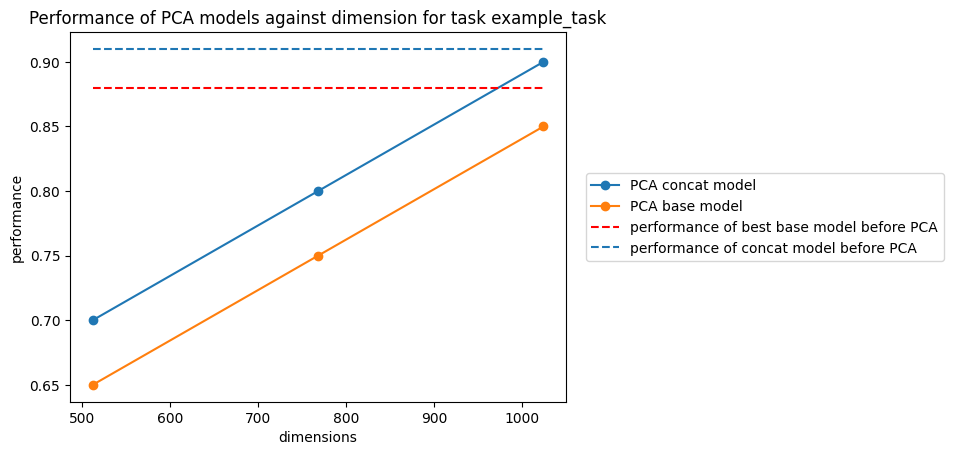

In [233]:

task = 'example_task'
x = [512,768,1024]
y = [0.7,0.8,0.9]
y2 = [0.65,0.75,0.85]
plt.plot(x, y, label='PCA concat model', marker='o')
plt.plot(x, y2, label='PCA base model', marker='o')
plt.hlines(0.88, xmin=512, xmax=1024, linestyles='dashed', label='performance of best base model before PCA', colors='red')
plt.hlines(0.91, xmin=512, xmax=1024, linestyles='dashed', label='performance of concat model before PCA')
plt.title(f"Performance of PCA models against dimension for task {task}")
plt.xlabel("dimensions")
plt.ylabel("performance")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)